# Exercise 4
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-05-19: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')
from pprint import pprint

from sklearn.linear_model import LinearRegression

# Notebook graphics settings 
%config InlineBackend.figure_format = 'svg'    # inline vector graphics
#%config InlineBackend.figure_format = 'retina' # medium resolution png:s
#plt.rcParams['figure.dpi'] = 120                # custom dpi setting png

## Task 1: Granger Causality

In [2]:
def VAR2(a0, A1, A2, sigma, x0, T):
    """
    Generate an d-variant AR(2) time series.
    """
    x = np.zeros((T, len(x0)))
    eps = np.random.multivariate_normal(np.zeros(2), sigma, size=T)
    x[0] = x0
    x[1] = a0 + A1.dot(x[0]) + eps[0]
    for t in range(2, T):
        x[t] = a0 + A1.dot(x[t-1]) + A2.dot(x[t-2]) + eps[t-1]
    return x

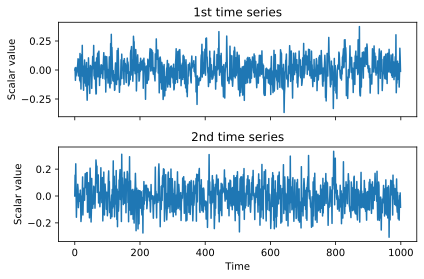

In [3]:
# Create a 2-variant AR(2) time series.
d = 2     # dimensions  
T = 1000  # timesteps
a0 = np.array([0, 0])                   
A1 = np.array([[0.2, 0], [-0.2, 0.1]])  
A2 = np.array([[0.1, 0], [-0.1, 0.1]])
sigma = np.array([[0.01, 0],[0, 0.01]]) # covariance matrix
x0 = np.array([0, 0])                   # initial conditions

x = VAR2(a0, A1, A2, sigma, x0, T)

# Plotting
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(x[:, 0], label='1st time series')
ax[0].set_title('1st time series')
ax[0].set_ylabel('Scalar value')
#ax[0].legend()

ax[1].plot(x[:, 1], label='2nd time series')
ax[1].set_title('2nd time series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Scalar value')
#ax[1].legend()
fig.tight_layout()
plt.show()

Since we know the coefficient matrices $A_1$ and $A_2$, I would believe that $x_1$ Granger causes $x_2$, and not the other way around. This is since both  $A_1[0,1] = A_2[0,1] = 0$, while $A_1[1,0] \neq 0$ and  $A_2[0,1] \neq 0$. Thus we have information flowing $x_1 \rightarrow x_2$, but $x_2 \not\rightarrow x_1$, determined by the off-diagonal terms, since

\begin{align}
    x_{1, t} \sim &A_1[0,0] x_{1, t-1} + A_1[0,1] x_{2, t-1} = A_1[0,0] x_{1, t-1}\\
    x_{2, t} \sim &A_1[1,0] x_{1, t-1} + A_1[1,1] x_{2, t-1} = A_1[1,0] x_{1, t-1} + A_1[1,1] x_{2, t-1}
\end{align}

and similarly for $A_2$.

In [4]:
def AR_fit(x, p):
    """
    Estimate the parameters of an Auto-regressive (AR) model 
    of order p on a scalar time series x.
    
    Parameters:
    -----------
    x: np.array shape=(T,)
        Scalar valued time series.
    p: int
        Order of the AR process.

    Returns:
    --------
    coef: np.array shape=(p,)
        Coefficient estimates of the AR(p) model.
    """
    T = len(x)
    y = x[p:] # target vector

    # Regressor matrix
    X = np.zeros((T-p, p+1))    # pre-allocation
    X[:,0] = 1                  # absorbing intercept by a column of ones.
    for i in range(1, p+1):
        X[:,i] = x[p-i:T-i]     # building the regressor matrix

    # Linear regression.
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    AR_coef = reg.coef_
    # AR_coef = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # Alternative method
    return AR_coef

def AR_predict(x, AR_coef):
    """
    One-step mean (i.e. without noise) predictions of an AR(p) model 
    on each timestep in time series x.
    """
    T = len(x)
    p = len(AR_coef)-1
    x_hat = np.zeros(T-p)
    for i, t in enumerate(range(p, T)):
        if t >= len(AR_coef):
            x_hat[i] = AR_coef[0] + AR_coef[1:].dot(x[t-1:t-len(AR_coef):-1]) 
        else:
            x_hat[i] = AR_coef[0] + AR_coef[1:].dot(x[t-1::-1])
    return x_hat

def logL_AR(x, p):
    """
    Fit a uni-variate AR(p) model to the time series x, and compute the log-likelihood.
    """
    coef = AR_fit(x, p)             # fit AR(p) model
    x_hat = AR_predict(x, coef)     # get one-step mean predictions
    eps = x[p:] - x_hat             # get one-step model residuals
    sigma2_hat = eps.dot(eps)/(T-p) # estimate variance of gaussian noise
    # Compute the log-likelihood:
    log_L = -0.5*(T-p)*np.log(2*np.pi) - 0.5*(T-p)*np.log(sigma2_hat) - 0.5*eps.dot(eps)/sigma2_hat
    return log_L

In [5]:
# Separate the two time series.
x1 = x[:, 0]
x2 = x[:, 1]

# Fit two uni-variate AR(2) models on each series individually, and compute the log-likelihood on each fit.
p = 2
logL_AR2_x1 = logL_AR(x1, p)
logL_AR2_x2 = logL_AR(x2, p)

pprint(logL_AR2_x1)
pprint(logL_AR2_x2)

868.1203752268034
845.2744714272967


In [6]:
# Fit one VAR(2) model to the dual-variate time series.
from statsmodels.tsa.api import VAR
model = VAR(x)
results = model.fit(maxlags=2)
#results.summary()

# Extracting coefficient matrices A_i and bias a_0.
a0_fit = results.params[0]
A1_fit = results.params[1:3].T
A2_fit = results.params[3:].T

def namestr(obj, namespace):
    # Return the variable names of obj as a string. 
    return [name for name in namespace if namespace[name] is obj]

# Printing the fitted coefficients.
for mat in [a0_fit, A1_fit, A2_fit]:
    print(f"{namestr(mat, globals())[0]} = ")
    pprint(mat)
    print()

a0_fit = 
array([ 0.00020072, -0.00301741])

A1_fit = 
array([[ 0.2260082 , -0.08515483],
       [-0.21352663,  0.05489792]])

A2_fit = 
array([[ 0.11669224, -0.03051946],
       [-0.06049912,  0.10763216]])



In [7]:
VAR2_coef = [a0_fit, A1_fit, A2_fit]

In [8]:
def VAR_predict(x, VAR_coef):
    """
    One-step mean (i.e. without noise) predictions of an VAR(p) model 
    on each timestep in the multi-variate time series x.
    """
    T, D = x.shape
    p = len(VAR_coef)-1
    x_hat = np.zeros((T-p, D))
    for i, t in enumerate(range(p, T)):
        x_hat[i] = VAR_coef[0][0] + np.sum([A.dot(x[t-1-j]) for j, A in enumerate(VAR2_coef[1:])], axis=0)
    return x_hat

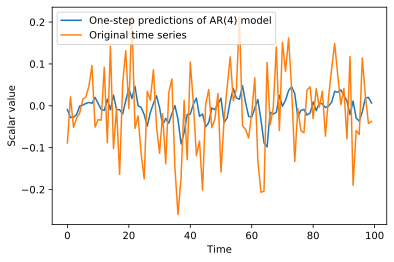

In [9]:
x_hat = VAR_predict(x, VAR2_coef)

plt.plot(x_hat[:, 0][:100], label='One-step predictions of AR(4) model')
plt.plot(x1[p:][:100], label='Original time series')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Scalar value')
plt.show()

In [10]:
t = 0
np.sum([A.dot(x[t-1-i]) for i, A in enumerate(VAR2_coef[1:])], axis=0)

array([ 0.01606997, -0.0059986 ])

In [11]:
[A.dot(x[t-1-i]) for i, A in enumerate(VAR2_coef[1:])]

[array([ 0.0044945 , -0.00210228]), array([ 0.01157546, -0.00389633])]

In [12]:
np.array([A.dot(x[t-1-i]) for i, A in enumerate(VAR2_coef[1:])])

array([[ 0.0044945 , -0.00210228],
       [ 0.01157546, -0.00389633]])

In [13]:
np.array([A.dot(x[t-1-i]) for i, A in enumerate(VAR2_coef[1:])]).sum(axis=1)

array([0.00239223, 0.00767913])

In [14]:
test = np.random.random((2,4)).T
test

array([[0.62633699, 0.76386227],
       [0.68259968, 0.17358217],
       [0.24096544, 0.00461611],
       [0.30821922, 0.43038053]])

In [15]:
test.sum(axis=0)

array([1.85812133, 1.37244108])